In [1]:
cd C:\\Users\\Sharuka Thirimanne\\Desktop\\FYP-ML-IDS

C:\Users\Sharuka Thirimanne\Desktop\FYP-ML-IDS


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from matplotlib.colors import ListedColormap
from sklearn import neighbors
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline

In [3]:
def load_train_dataset():
    df_train = pd.read_csv('Datasets/UNSW_train-set.csv')
    df_train.drop(['index'], axis = 'columns' , inplace = True)
    df_train.drop(['attack_cat'], axis = 'columns' , inplace = True)
    
    
    for col in ['proto','service','state']:
        df_train[col] = df_train[col].astype('category')
        
    others1 = df_train['proto'].value_counts().index[8:]
    label = 'Other'
    # apply new category label
    df_train['proto'] = df_train['proto'].cat.add_categories([label])
    df_train['proto'] = df_train['proto'].replace(others1, label)
    
    others3 = df_train['service'].value_counts().index[8:]
    # apply new category label
    df_train['service'] = df_train['service'].cat.add_categories([label])
    df_train['service'] = df_train['service'].replace(others3, label)
    
    others5 = df_train['state'].value_counts().index[4:]
    # apply new category label
    df_train['state'] = df_train['state'].cat.add_categories([label])
    df_train['state'] = df_train['state'].replace(others5, label)
    
    df_train.drop_duplicates(keep='first',inplace=True)
    
    limit1 = df_train.shape[1]-1
    
    X_train = df_train.iloc[:,0:limit1]
    Y_train = df_train.iloc[:,limit1]
    
    return  X_train, Y_train,  df_train

X_train, Y_train,  df_train = load_train_dataset()

In [4]:
def load_test_dataset():
    df_test = pd.read_csv('Datasets/UNSW_test-set.csv')
    df_test.drop(['index'], axis = 'columns' , inplace = True)
    df_test.drop(['attack_cat'], axis = 'columns' , inplace = True)
    
    #Below categories in the state feature are available in the test set but not in the training set
    df_test.drop(df_test[df_test['state'] == 'CLO'].index, inplace = True)
    df_test.drop(df_test[df_test['state'] == 'ACC'].index, inplace = True)
    
    
    
    for col in ['proto','service','state']:
        df_test[col] = df_test[col].astype('category')
        
    label = 'Other'
    
    others2 = df_test['proto'].value_counts().index[8:]
    # apply new category label
    df_test['proto'] = df_test['proto'].cat.add_categories([label])
    df_test['proto'] = df_test['proto'].replace(others2, label)
    
    others4 = df_test['service'].value_counts().index[8:]
    # apply new category label
    df_test['service'] = df_test['service'].cat.add_categories([label])
    df_test['service'] = df_test['service'].replace(others4, label)
    
    others6 = df_test['state'].value_counts().index[4:]
    # apply new category label
    df_test['state'] = df_test['state'].cat.add_categories([label])
    df_test['state'] = df_test['state'].replace(others6, label)
    
    df_test.drop_duplicates(keep='first',inplace=True)
    
    limit2 = df_test.shape[1]-1
    
    X_test = df_test.iloc[:,0:limit2]
    Y_test = df_test.iloc[:,limit2]
    
    return X_test, Y_test,df_test

X_test, Y_test ,df_test = load_test_dataset()

Performed one hot encoding on training set and test set separetely to avoid data leakage. 

In [5]:
categorical_cols = ['proto','service','state']

In [6]:
# Training dataset one hot encoding
ohe1 = OneHotEncoder(handle_unknown = 'ignore')
ohe1.fit(X_train[categorical_cols])
array_hot_encoded1 = ohe1.transform(X_train[categorical_cols]).toarray()
data_hot_encoded1 = pd.DataFrame(array_hot_encoded1, index=X_train.index)
X_train = X_train.drop(columns=categorical_cols)
X_train = pd.concat([data_hot_encoded1,X_train], axis=1)

In [7]:
print(X_train.shape)
print(Y_train.shape)

(122378, 62)
(122378,)


In [12]:
X_train_save = pd.DataFrame(X_train)

In [8]:
# Test dataset one hot encoding
#ohe1 = OneHotEncoder(handle_unknown = 'ignore')
array_hot_encoded2 = ohe1.transform(X_test[categorical_cols]).toarray()
data_hot_encoded2 = pd.DataFrame(array_hot_encoded2, index=X_test.index)
X_test = X_test.drop(columns=categorical_cols)
X_test = pd.concat([data_hot_encoded2,X_test], axis=1)

In [ ]:
'''
#Get missing columns in the training test
missing_cols = set(X_train.columns) - set(X_test.columns)
#Add a missing column in test set with default value equal to 0
for c in missing_cols:
    X_test[c] = 0
# Ensure the order of column in the test set is in the same order than in train set
X_test = X_test[X_train.columns]


In [34]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [19]:
knn_classifier = KNeighborsClassifier(n_neighbors = 23, p = 2, weights ='distance').fit(X_train,Y_train)

In [20]:
test_predictions = knn_classifier.predict(X_test)

print("Cross-Validation set accuracy: {:.6f} %".format((cross_val_score(knn_classifier, X_train, Y_train, 
                                                                        cv=5,scoring='recall').mean())*100))
print("Train set accuracy           : {:.6f} %".format(knn_classifier.score(X_train,Y_train)*100))
print("Test set accuracy            : {:.6f} %".format(accuracy_score(Y_test, test_predictions)*100))

Cross-Validation set accuracy: 93.516502 %
Train set accuracy           : 99.802252 %
Test set accuracy            : 61.425303 %


In [23]:
def plot_cm(labels, predictions, p=0.5):
    cm = confusion_matrix(labels, predictions > p)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

    plt.text(0.3,2.6,'True Negatives  : '+ str(cm[0][0]),size=14)
    plt.text(0.3,2.8,'False Positives   : '+ str(cm[0][1]),size=14)
    plt.text(0.3,3,'False Negatives : '+ str(cm[1][0]),size=14)
    plt.text(0.3,3.2,'True Positives    : '+ str(cm[1][1]),size=14)

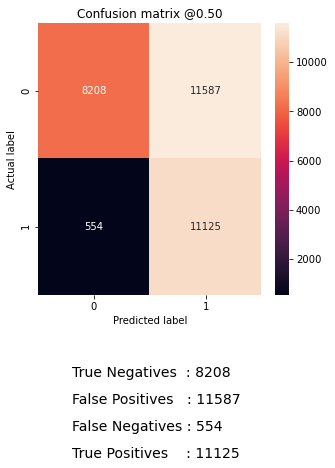

In [24]:
plot_cm(Y_test, test_predictions)

In [25]:
print(classification_report(Y_test, test_predictions))

              precision    recall  f1-score   support

           0       0.94      0.41      0.57     19795
           1       0.49      0.95      0.65     11679

    accuracy                           0.61     31474
   macro avg       0.71      0.68      0.61     31474
weighted avg       0.77      0.61      0.60     31474



c:\users\sharuka thirimanne\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  app.launch_new_instance()


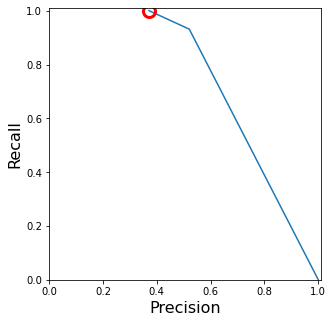

In [15]:
from sklearn.metrics import precision_recall_curve

#y_scores_lr = knn_classifier.fit(X_train, Y_train).decision_function(X_test)
precision, recall, thresholds = precision_recall_curve(Y_test, test_predictions)
closest_zero = np.argmin(np.abs(thresholds))
closest_zero_p = precision[closest_zero]
closest_zero_r = recall[closest_zero]

plt.figure(figsize=(10,5))
plt.xlim([0.0, 1.01])
plt.ylim([0.0, 1.01])
plt.plot(precision, recall, label='Precision-Recall Curve')
plt.plot(closest_zero_p, closest_zero_r, 'o', markersize = 12, fillstyle = 'none', c='r', mew=3)
plt.xlabel('Precision', fontsize=16)
plt.ylabel('Recall', fontsize=16)
plt.axes().set_aspect('equal')
plt.show()

In [16]:
from sklearn.metrics import roc_curve, auc

c:\users\sharuka thirimanne\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  del sys.path[0]


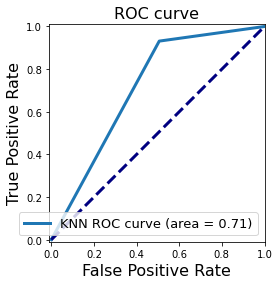

In [17]:
fpr_lr, tpr_lr, _ = roc_curve(Y_test, test_predictions)
roc_auc_lr = auc(fpr_lr, tpr_lr)

plt.figure()
plt.xlim([-0.01, 1.00])
plt.ylim([-0.01, 1.01])
plt.plot(fpr_lr, tpr_lr, lw=3, label='KNN ROC curve (area = {:0.2f})'.format(roc_auc_lr))
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc='lower right', fontsize=13)
plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')
plt.axes().set_aspect('equal')
plt.show()

In [18]:
n_neighbors = list(range(1,25,2))
p=[1,2]

param_grid = [
    {'n_neighbors' : n_neighbors,
     'p' :p
    },
]

optimal_params = GridSearchCV(
    estimator = knn_classifier,
    param_grid = param_grid,
    cv=2,
    scoring ='accuracy',
    verbose = 2
)

optimal_params.fit(X_train,Y_train)
print(optimal_params.best_params_)

Fitting 2 folds for each of 24 candidates, totalling 48 fits
[CV] n_neighbors=1, p=1 ..............................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ............................... n_neighbors=1, p=1, total= 2.7min
[CV] n_neighbors=1, p=1 ..............................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.7min remaining:    0.0s


[CV] ............................... n_neighbors=1, p=1, total= 4.6min
[CV] n_neighbors=1, p=2 ..............................................
[CV] ............................... n_neighbors=1, p=2, total= 2.5min
[CV] n_neighbors=1, p=2 ..............................................
[CV] ............................... n_neighbors=1, p=2, total= 3.1min
[CV] n_neighbors=3, p=1 ..............................................
[CV] ............................... n_neighbors=3, p=1, total= 2.5min
[CV] n_neighbors=3, p=1 ..............................................
[CV] ............................... n_neighbors=3, p=1, total= 3.2min
[CV] n_neighbors=3, p=2 ..............................................
[CV] ............................... n_neighbors=3, p=2, total= 3.3min
[CV] n_neighbors=3, p=2 ..............................................
[CV] ............................... n_neighbors=3, p=2, total= 3.3min
[CV] n_neighbors=5, p=1 ..............................................
[CV] .

[Parallel(n_jobs=1)]: Done  48 out of  48 | elapsed: 144.6min finished


{'n_neighbors': 23, 'p': 2}
